# Calculating the MTF from the Fourier transform

In [1]:
from srayan_dof import *
from scipy.optimize import curve_fit
import pandas as pd

In [2]:
BASE_PATH = '../../data_store/2022-10-31 dof contd/aperture/'
f22 = BASE_PATH + '2022-10-31-f22 depth sweep wide range stack/MMStack_Pos0.ome.tif'
E = np.arange(25, -1, -1)

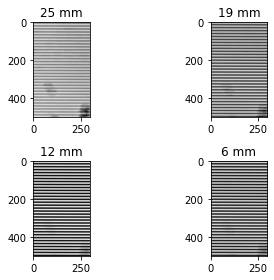

In [3]:
im = load_disp_img(f22, E, disp=True)

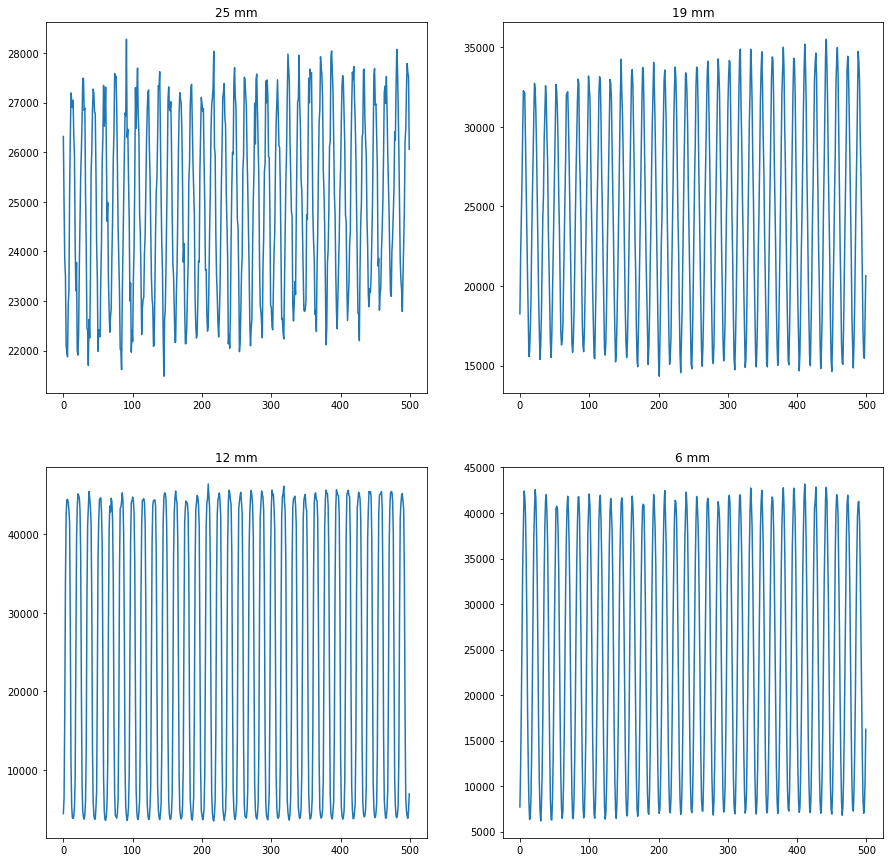

In [4]:
line_prof_splash(im, E)

## Ideal square wave

- KK obtained measurements:
    - coarse grating: 5 lines/mm
    - 6.45 micron per pixel

0.2 mm per line = 200 micron per line  
0.155 pixels per micron

==> 31 pixels per line

Fitted: 31.359 pixels per line


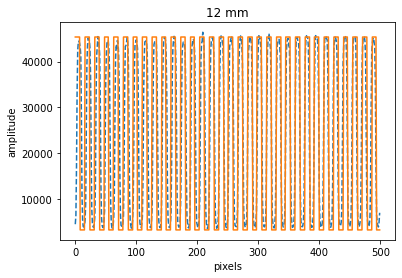

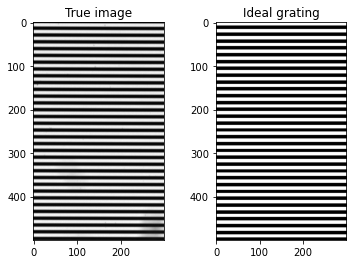

In [5]:
idealsquare, idealgrating = fit_square_to_lineprof(im, 13, E, disp=True)

## Direct division of ideal and true Fourier transforms

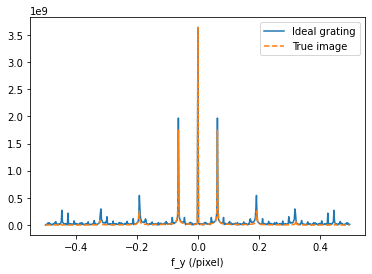

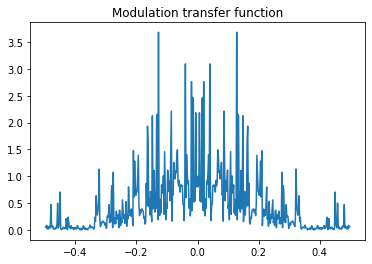

In [6]:
mtf = get_mtf(im, 13, E, disp=True)

## Attempts at getting a smoother MTF

### Fitting a sinc function to the peak positions

(as this should be the envelope)

In [7]:
def get_mtf_smooth(im, frame, positions, disp=False):
    
    idealsquare, idealgrating = fit_square_to_lineprof(im, frame, positions)

    ft_im, freqs_im = fourier(im[13])
    ft_ideal, freqs_ideal = fourier(idealgrating)
    
    peaks_im, props_im = fft_find_peaks(im[13], disp=True)
    peaks_ideal, props_ideal = fft_find_peaks(idealgrating, thresh=0.25e9, disp=True)
    
    def sinc_func(x, a, b, h):
        return(a*(np.sinc((b*x) - h))**2)
    
    def fit_sinc_curve(peaks, props, ft, freqs):
        # adapted from https://stackoverflow.com/a/49676284
        ydata = props['peak_heights']
        xdata = np.fft.fftshift(freqs[0])[peaks]
        k = ydata.argmax()
        p0 = [ydata[k], 10, xdata[k]]
        popt, pcov = curve_fit(sinc_func, xdata, ydata, p0=p0)
        
        plt.plot(np.fft.fftshift(freqs[0]), (np.abs(ft)[:,ft.shape[1]//2]), label='ft')
        # plt.plot(xdata, ydata, '--', label='FT peak positions')
        plt.plot(freqs[0], sinc_func(freqs[0], *popt), label='fitted sinc')
        plt.legend()
        plt.show()
        print(popt)
        return sinc_func(freqs[0], *popt)
    
    
    sinc_image = fit_sinc_curve(peaks_im, props_im, ft_im, freqs_im)
    sinc_ideal = fit_sinc_curve(peaks_ideal, props_ideal, ft_ideal, freqs_ideal)
    
    mtf = sinc_image / sinc_ideal
    
    plt.plot(freqs_im[0], mtf)
    plt.title('MTF = FT{image} / FT{ideal}')
    plt.show()


    return mtf

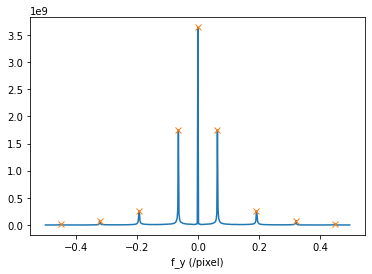

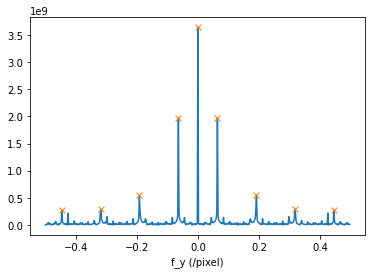

/home/srayan/miniconda3/envs/physics/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


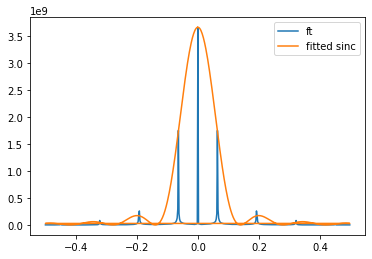

/home/srayan/miniconda3/envs/physics/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[3.66040349e+09 7.16205657e+00 1.38017721e-10]


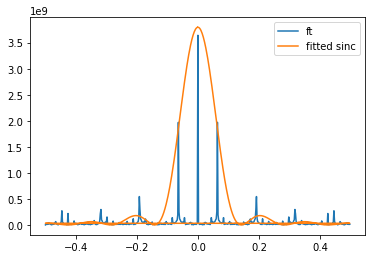

[3.79525240e+09 7.03493848e+00 3.55916015e-10]


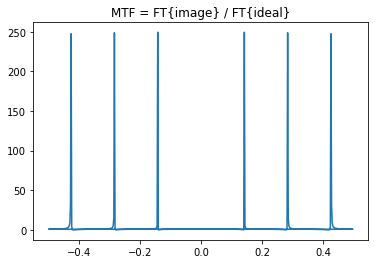

In [8]:
mtf = get_mtf_smooth(im, 13, E, disp=True)

Can't get a good fit. 

### Diving only values above a certain threshold

Expect divide-by-zero errors in most places, except where ideal FT is sufficiently greater than true FT

In [9]:
from scipy.signal import lfilter

def get_mtf_threshold(im, frame, positions, disp=False):
    idealsquare, idealgrating = fit_square_to_lineprof(im, frame, positions)

    ft_im, freqs_im = fourier(im[frame])
    ft_ideal, freqs_ideal = fourier(idealgrating)
    
    # stolen from https://stackoverflow.com/a/37599921
    n = 1
    b = [1.0 / n] * n
    a = 1
    ft_ideal_smooth = ft_ideal.copy()
    ft_ideal_smooth[np.abs(ft_ideal) < 0.2e9] = 0 

    mtf = ((np.abs(ft_im)[:,ft_im.shape[1]//2])/(np.abs(ft_ideal_smooth)[:,ft_ideal_smooth.shape[1]//2]))[1:]

    if disp:
        plt.plot(np.fft.fftshift(freqs_ideal[0]), (np.abs(ft_ideal_smooth)[:,ft_ideal_smooth.shape[1]//2]), label='Ideal grating')
        plt.plot(np.fft.fftshift(freqs_im[0]), (np.abs(ft_im)[:,ft_im.shape[1]//2]), '--', label='True image')
        plt.xlabel('f_y (/pixel)')
        plt.legend()
        plt.show()
        
        plt.plot(np.fft.fftshift(freqs_im[0])[1:], mtf)
        plt.title('Modulation transfer function')
        plt.show()

    return mtf

/tmp/ipykernel_20163/701933170.py:16: RuntimeWarning: divide by zero encountered in true_divide
  mtf = ((np.abs(ft_im)[:,ft_im.shape[1]//2])/(np.abs(ft_ideal_smooth)[:,ft_ideal_smooth.shape[1]//2]))[1:]


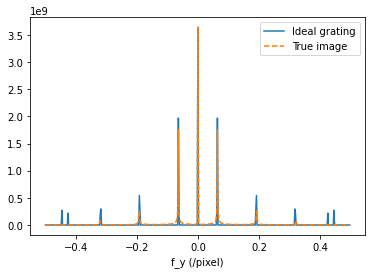

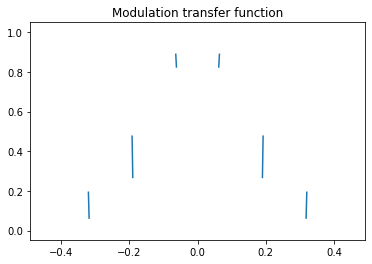

In [10]:
mtf = get_mtf_threshold(im, 13, E, disp=True)

Lines appear - are points at the top/bottom of these samples of our MTF?

### Dividing the peaks

Plan:

- [X] Get the peak indices from true FT
- [ ] Check the _same_ indices in the ideal FT (as peak positions should be the same)
    - This ensures we have the same number of peaks in true and ideal FTs, without having to tweak thresholds
    - However, may be less robust - what if the peak positions _aren't_ the same?
- [ ] Divide the peak heights and plot against fft-frequencies
- [ ] Can we fit a theoretical MTF curve to this?
    - Probably isn't an equation that can theoretically describe manufacturing tolerances and other real-world factors
    - So how else can we get more than three points sampling our MTF? An even coarser grating? An edge?

In [11]:
def get_mtf_peakdivide(im, frame, positions, disp=False):
    
    idealsquare, idealgrating = fit_square_to_lineprof(im, frame, positions)

    ft_im, freqs_im = fourier(im[13])
    ft_ideal, freqs_ideal = fourier(idealgrating)
    
    peaks_im, props_im = fft_find_peaks(im[13], disp=True)
    peaks_ideal, props_ideal = fft_find_peaks(idealgrating, thresh=0.25e9, disp=True)
    
    d = {'image_indices': peaks_im,
         'image_heights': props_im['peak_heights'],
         'ideal_indices': peaks_ideal,
         'ideal_heights': props_ideal['peak_heights']}
    
    df = pd.DataFrame(data=d)
    
    image_indices = df['image_indices'].tolist()
    df['ideal_heights_at_image_indices'] = np.abs(ft_ideal)[:,ft_im.shape[1]//2][image_indices]
    ideal_indices = df['ideal_indices'].tolist()
    df['image_heights_at_ideal_indices'] = np.abs(ft_im)[:,ft_im.shape[1]//2][ideal_indices]

    return df, freqs_im

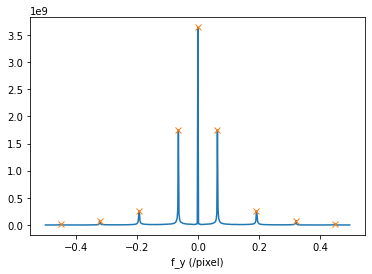

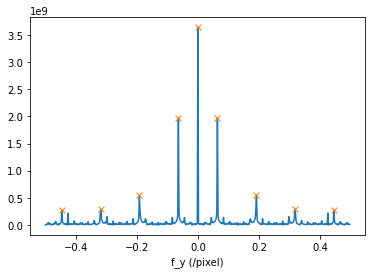

In [12]:
df, freqs = get_mtf_peakdivide(im, 13, E, disp=True)

In [13]:
df

,image_indices,image_heights,ideal_indices,ideal_heights,ideal_heights_at_image_indices,image_heights_at_ideal_indices
0,25,2.227497e+07,27,2.710961e+08,3.152552e+07,1.199879e+06
1,89,8.163223e+07,91,2.964308e+08,7.197304e+07,1.869872e+07
2,154,2.589321e+08,154,5.443207e+08,5.443207e+08,2.589321e+08
3,218,1.749314e+09,218,1.969579e+09,1.969579e+09,1.749314e+09
4,250,3.637684e+09,250,3.640472e+09,3.640472e+09,3.637684e+09
5,282,1.749314e+09,282,1.969579e+09,1.969579e+09,1.749314e+09
6,346,2.589321e+08,346,5.443207e+08,5.443207e+08,2.589321e+08
7,411,8.163223e+07,409,2.964308e+08,7.197304e+07,1.869872e+07
8,475,2.227497e+07,473,2.710961e+08,3.152552e+07,1.199879e+06


So peak positions aren't quite the same...

How much does it matter?

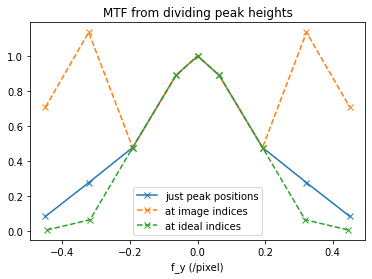

In [14]:
image_indices = df['image_indices'].tolist()
ideal_indices = df['ideal_indices'].tolist()
plt.plot(np.fft.fftshift(freqs[0])[image_indices], df['image_heights']/df['ideal_heights'], '-x', label='just peak positions')
plt.plot(np.fft.fftshift(freqs[0])[image_indices], df['image_heights']/df['ideal_heights_at_image_indices'], '--x', label='at image indices')
plt.plot(np.fft.fftshift(freqs[0])[ideal_indices], df['image_heights_at_ideal_indices']/df['ideal_heights'], '--x', label='at ideal indices')
plt.legend()
plt.xlabel('f_y (/pixel)')
plt.title('MTF from dividing peak heights')
plt.show()

Quite a lot... - which one is the most correct way of sampling the MTF?

Perhaps we could take the frequency to be the mean of the peak positions? But does this have any physical justification? Should we expect the peak positions to move?

Checking other image slices:

In [20]:
def get_mtf_peakdivide(im, frame, positions, thresh=0.25e9):
    
    idealsquare, idealgrating = fit_square_to_lineprof(im, frame, positions)

    ft_im, freqs_im = fourier(im[13])
    ft_ideal, freqs_ideal = fourier(idealgrating)
    
    peaks_im, props_im = fft_find_peaks(im[13], disp=True)
    peaks_ideal, props_ideal = fft_find_peaks(idealgrating, thresh=thresh, disp=True)
    
    d = {'image_indices': peaks_im,
         'image_heights': props_im['peak_heights'],
         'ideal_indices': peaks_ideal,
         'ideal_heights': props_ideal['peak_heights']}
    
    df = pd.DataFrame(data=d)
    
    image_indices = df['image_indices'].tolist()
    df['ideal_heights_at_image_indices'] = np.abs(ft_ideal)[:,ft_im.shape[1]//2][image_indices]
    ideal_indices = df['ideal_indices'].tolist()
    df['image_heights_at_ideal_indices'] = np.abs(ft_im)[:,ft_im.shape[1]//2][ideal_indices]
    
    plt.plot(np.fft.fftshift(freqs[0])[image_indices], df['image_heights']/df['ideal_heights'], '-x', label='just peak positions')
    plt.plot(np.fft.fftshift(freqs[0])[image_indices], df['image_heights']/df['ideal_heights_at_image_indices'], '--x', label='at image indices')
    plt.plot(np.fft.fftshift(freqs[0])[ideal_indices], df['image_heights_at_ideal_indices']/df['ideal_heights'], '--x', label='at ideal indices')
    plt.legend()
    plt.xlabel('f_y (/pixel)')
    plt.title('MTF from dividing peak heights')
    plt.show()

    return

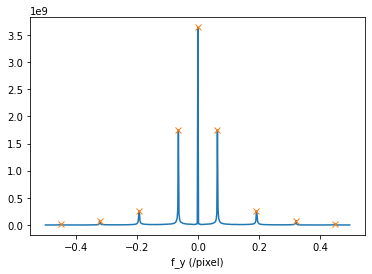

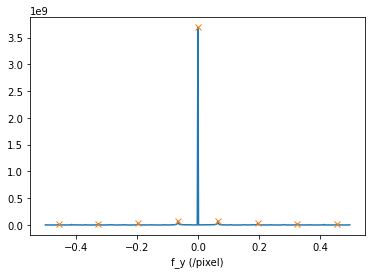

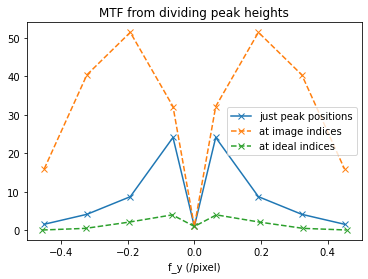

In [28]:
get_mtf_peakdivide(im, 3, E, thresh=0.012e9)

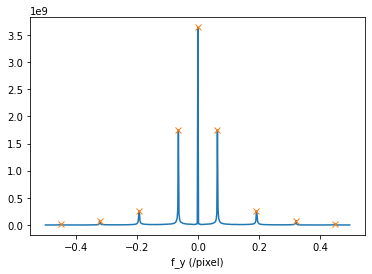

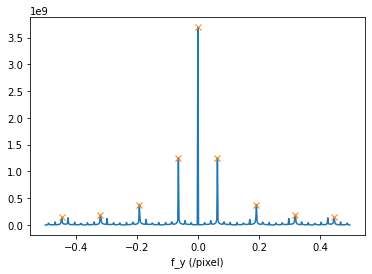

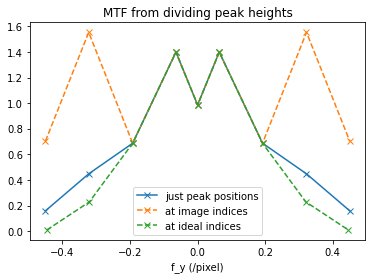

In [35]:
get_mtf_peakdivide(im, 20, E, thresh=0.135e9)